# Fairness In AI

In this practical session, we will focus on ways to measure model fairness as well as introduce some synthetic ways to generate images. The first part is focused on generation through DCGAN, then with a diffusion model approach and finally, we'll see the impact of dataset balancing on performances in Face Recognition. We will focus on demographic biases during this session. In order to study these biases we will use FairFace during this practical as well as the FavCI2D dataset in order to classify the images.

Please go to this link https://drive.google.com/drive/folders/1d4r1KIJpznckVrbdmE6blmzf86ce29r0?usp=sharing. Click on the folder name (MasterIADrive) then go to organize and click on add shortcut, go to "all locations" then mydrive then add

In [5]:
# prompt: mount google drive account, create a variable storing the path toward a datafolder within the drive folder then move the img_align_celeba.zip file within this folder to the current dir and unzip it

from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

data_folder_path = '/content/drive/My Drive/'

import os


ModuleNotFoundError: No module named 'google.colab'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 59.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [5]:
#%matplotlib inline
!pip install dlib
import argparse
import pytorch_lightning as pl
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import torchvision
from pytorch_lightning import seed_everything
import torchmetrics
from pytorch_lightning.loggers import CSVLogger

def flatten_paths_recursively(root_path:str, output_absolute_path:bool=False, depth: "int|None" = None, exclusion_list:'list[str]' = [], keep_dir=False, parent_folder=None):
    """
    return the list of the paths of all the file contained in root_path
    INPUT:
    - root_path
    - output_absolute_path : if set to True, will store the absolute path
    - depth : if not None will stop the elts search at the given step
    - exclusion_list : will ignore the files whose name repsect the regexp stored
    - keep_dir : keep dir within returned list
    """
    result = []
    if os.path.isfile(root_path) or(not(depth is None) and depth == 0 ):
        if output_absolute_path:
            return [os.path.abspath(root_path)]
        return [os.path.relpath(root_path, parent_folder)]

    root_path = format_prepath(root_path)
    if parent_folder is None:
        print("getting all paths")
        iterator = tqdm(os.listdir(root_path))
        parent_folder = root_path
    else:
        iterator = os.listdir(root_path)
    if keep_dir:
        result.append(root_path[:-1])
    for elt in iterator:
        elt_path = root_path + elt
        result += flatten_paths_recursively(elt_path, output_absolute_path, None if depth is None else depth - 1, exclusion_list=exclusion_list, keep_dir=keep_dir, parent_folder=parent_folder)
    return result

## Data stuff

In [6]:
zip_file_path_in_drive = os.path.join(data_folder_path, 'img_align_celeba.zip')
!cp "{zip_file_path_in_drive}" .
!unzip -q img_align_celeba.zip

In [7]:
class CelebaSet:
    def __init__(self,imgs_path, transform):
        self.imgs_path = imgs_path
        self.transform = transform

    def __getitem__(self, i):
        image = Image.open(self.imgs_path[i])
        return self.transform(image)
    def __len__(self):
        return len(self.imgs_path)

In [8]:
class CelebaModule(pl.LightningDataModule):
    def __init__(self, imgs_root, num_workers = 10, batch_size=128, image_size =64):
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.image_size = image_size

        self.imgs_root = imgs_root
        content = os.listdir(imgs_root)
        if os.path.isdir(content[0]):
            imgs = flatten_paths_recursively
        else:
            imgs = os.listdir(imgs_root)
        self.imgs = [os.path.join(imgs_root, img) for img in imgs]

        self.transform=transforms.Compose([
                               transforms.Resize((self.image_size, self.image_size)),
                               # transforms.CenterCrop(self.image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
    def setup(self, stage=None):
        # Split the data into train, val and test sets
        train_len = int(len(self.imgs) * 0.8)
        val_len = len(self.imgs) - train_len
        train_set, val_set = torch.utils.data.random_split(self.imgs, [train_len, val_len])
        self.train_set = CelebaSet(train_set, self.transform)
        self.val_set = CelebaSet(val_set, self.transform)

    def train_dataloader(self):
        # Return the train dataloader
        return torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers )

    def val_dataloader(self):
        # Return the val dataloader
        return torch.utils.data.DataLoader(self.val_set, batch_size=self.batch_size, num_workers=self.num_workers)




In [9]:
# Root directory for dataset
dataroot = "img_align_celeba"

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
batch_size = 64
image_size = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
workers=10

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


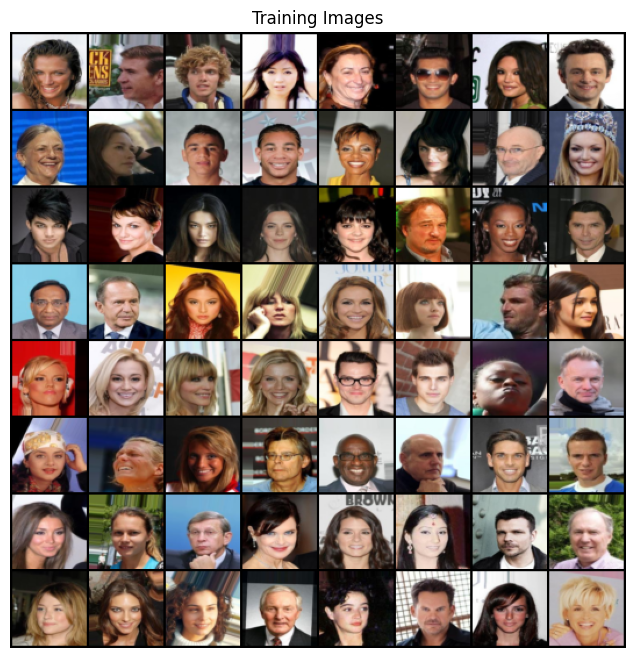

In [10]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
data_module = CelebaModule(imgs_root=dataroot,batch_size= batch_size, image_size = image_size, num_workers=workers)
data_module.setup()
# Create the dataloader
dataloader = data_module.train_dataloader()

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Model stuff

In [11]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
class BasicGeneratorBlock(nn.Module):
    """ BasicBlock for DCGAn
    """
    def __init__(self, nb_features_in, nn_features_out, kernel_size, stride=1, padding=0, shortcut=None, anchor = False):
        super(BasicGeneratorBlock, self).__init__()
        if shortcut is not None:
            self.shortcut_layer = shortcut
        else:
            self.shortcut_layer = lambda x, res: torch.zeros_like(res, device=x.device)
        self.res_layer = nn.Sequential(
            nn.ConvTranspose2d( nb_features_in, nn_features_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(nn_features_out),
            nn.ReLU(True))

    def forward(self, x):

        res = self.res_layer(x)
        shortcut = self.shortcut_layer(x, res)
        return shortcut + res



In [13]:

class Generator(nn.Module):
    def __init__(self, ngf, nz, nc, depth = 4):
        super(Generator, self).__init__()
        kernel_size = depth // 4 * 4
        layers = [BasicGeneratorBlock(nz, ngf *  2**(depth - 1), kernel_size, 1, 0)]
        for i in range(depth - 1, 0, -1):
            if (depth - i) % 4 == 0:
                kernel_size = max(4, kernel_size // 2)
            layers.append(BasicGeneratorBlock(ngf *  2**(i), ngf *  2**(i-1), kernel_size, 2, 1))

        layers.append(nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)


    def forward(self, input):
        return self.main(input)

In [14]:
class BasicDiscriminatorBlock(nn.Module):
    """
    BasicBlock for DCGAn
    """
    def __init__(self, nb_features_in, nn_features_out, kernel_size, stride=2, padding=0, shortcut=None, anchor = False):
        super(BasicDiscriminatorBlock, self).__init__()
        if shortcut is not None:
            self.shortcut_layer = shorcut
        else:
            self.shortcut_layer = lambda x, res: torch.zeros_like(res, device=x.device)
        self.res_layer = nn.Sequential(
            nn.Conv2d(nb_features_in, nn_features_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(nn_features_out),
            nn.LeakyReLU(0.2, inplace=True))


    def forward(self, x):
        res = self.res_layer(x)
        shortcut = self.shortcut_layer(x, res)

        return shortcut + res


In [15]:
class Discriminator(nn.Module):
    def __init__(self, ndf, nc, depth = 4):
        super(Discriminator, self).__init__()
        kernel_size = depth // 4 * 4
        layers = [nn.Conv2d(nc, ndf, kernel_size, 2, 1, bias=False),nn.LeakyReLU(0.2, inplace=True)]

        for i in range(0, depth - 1):
            if i % 4 == 0:
                kernel_size = max(4, kernel_size // 2)
            layers.append(BasicDiscriminatorBlock(ndf *  2**(i), ndf *  2**(i+1), kernel_size, 2, 1))

        layers.append(nn.Conv2d(ndf * 2**(depth - 1), 1, 4, 1, 0, bias=False))
        layers.append(nn.Sigmoid())
        self.main = nn.Sequential(*layers)

    def forward(self, input):
        return self.main(input).squeeze()

In [16]:
class DCGANTrain(pl.LightningModule):
    def __init__(self, learning_rate=0.0002, beta1=0.5, nc=3, ngf=64, nz=100, ndf=64, depth=4, generator_inner_repetition=1, images_folder="images_logs"):
        super().__init__()
        self.generator_inner_repetition = generator_inner_repetition
        self.nz = nz
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.automatic_optimization = False  # Disable automatic optimization

        self.register_buffer("device_tensor", torch.tensor(0))
        self.netG = Generator(ngf, nz, nc, depth).to(self.device_tensor.device)
        self.netG.apply(weights_init)
        self.netD = Discriminator(ndf, nc, depth).to(self.device_tensor.device)
        self.netD.apply(weights_init)

        self.criterion = nn.BCELoss()
        self.accuracy = torchmetrics.classification.Accuracy(task="binary")

        os.makedirs(images_folder, exist_ok=True)
        self.image_logs = os.path.join(images_folder, f"training_{len(os.listdir(images_folder)) + 1}")
        os.makedirs(self.image_logs)

    def forward(self, nb_images=1, convert_to_image=False):
        with torch.no_grad():
            tensors = self.netG(torch.randn(nb_images, self.nz, 1, 1, device=self.device_tensor.device))
            return_images = []
            for tensor in tensors:
                correct_range_tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min()).detach().cpu()
                if convert_to_image:
                    correct_range_tensor = transforms.ToPILImage()(correct_range_tensor)
                return_images.append(correct_range_tensor)
            return return_images

    def training_step(self, batch, batch_idx):
        real_images = batch
        batch_size = real_images.size(0)
        device = self.device_tensor.device

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Get the optimizers
        optimizerD, optimizerG = self.optimizers()

        if batch_idx % 2 == 0:  # Train Discriminator
            z = torch.randn(batch_size, self.nz, 1, 1, device=device)
            fake_images = self.netG(z).detach()

            real_preds = self.netD(real_images).view(-1, 1)  # Fix shape
            fake_preds = self.netD(fake_images).view(-1, 1)  # Fix shape

            loss_real = self.criterion(real_preds, real_labels)
            loss_fake = self.criterion(fake_preds, fake_labels)
            loss_D = loss_real + loss_fake

            optimizerD.zero_grad()
            self.manual_backward(loss_D)
            optimizerD.step()

            self.log('train_discriminator_loss', loss_D, on_step=True, on_epoch=True, logger=True)
            return loss_D

        # Train Generator
        z = torch.randn(batch_size, self.nz, 1, 1, device=device)
        fake_images = self.netG(z)
        fake_preds = self.netD(fake_images).view(-1, 1)  # Fix shape

        loss_G = self.criterion(fake_preds, real_labels)

        optimizerG.zero_grad()
        self.manual_backward(loss_G)
        optimizerG.step()

        self.log('train_generator_loss', loss_G, on_step=True, on_epoch=True, logger=True)
        return loss_G

    def validation_step(self, batch, batch_idx):
        real_images = batch
        batch_size = real_images.size(0)
        device = self.device_tensor.device

        z = torch.randn(batch_size, self.nz, 1, 1, device=device)
        fake_images = self.netG(z).detach()

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        real_preds = self.netD(real_images).view(-1, 1)  # Fix shape
        fake_preds = self.netD(fake_images).view(-1, 1)  # Fix shape

        accuracy_fake = self.accuracy(fake_preds, fake_labels)
        accuracy_real = self.accuracy(real_preds, real_labels)

        self.log("val_accuracy_fake_images", accuracy_fake, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_accuracy_real_images", accuracy_real, on_epoch=True, logger=True, prog_bar=True)

        epoch_images = os.path.join(self.image_logs, f"{self.current_epoch}.png")
        if not os.path.exists(epoch_images):
            grid = torchvision.utils.make_grid(fake_images, normalize=True)
            torchvision.utils.save_image(grid, epoch_images, normalize=True)

    def on_validation_end(self):
        gc.collect()

    def configure_optimizers(self):
        optimizerD = optim.Adam(self.netD.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))
        optimizerG = optim.Adam(self.netG.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))
        return [optimizerD, optimizerG], []


In [17]:
seed_everything(42, workers=True)
data_module = CelebaModule(imgs_root=dataroot,batch_size= batch_size , image_size = image_size, num_workers=workers)
trainModule = DCGANTrain()


INFO:lightning_fabric.utilities.seed:Seed set to 42


In [18]:
trainModule(5)

[tensor([[[0.5112, 0.5350, 0.5012,  ..., 0.5224, 0.4830, 0.5431],
          [0.4932, 0.5173, 0.5025,  ..., 0.5618, 0.3962, 0.4540],
          [0.4731, 0.5812, 0.2988,  ..., 0.5434, 0.5179, 0.4936],
          ...,
          [0.4832, 0.5606, 0.3946,  ..., 0.4764, 0.4135, 0.5171],
          [0.4721, 0.6465, 0.3927,  ..., 0.6551, 0.3124, 0.4939],
          [0.4890, 0.4479, 0.4733,  ..., 0.4680, 0.4952, 0.4959]],
 
         [[0.5268, 0.5748, 0.5276,  ..., 0.5333, 0.5122, 0.5529],
          [0.4957, 0.4796, 0.3905,  ..., 0.5487, 0.4760, 0.5266],
          [0.6092, 0.5151, 0.4784,  ..., 0.5822, 0.4814, 0.5150],
          ...,
          [0.5185, 0.5230, 0.3906,  ..., 0.5279, 0.4889, 0.5257],
          [0.5927, 0.5434, 0.4828,  ..., 0.6452, 0.3414, 0.5624],
          [0.5408, 0.4633, 0.5214,  ..., 0.4835, 0.5408, 0.5146]],
 
         [[0.4990, 0.5092, 0.5127,  ..., 0.4207, 0.4859, 0.5033],
          [0.5066, 0.5566, 0.5185,  ..., 0.4764, 0.6174, 0.4963],
          [0.5116, 0.4773, 0.4822,  ...,

In [20]:
trainer = pl.Trainer(max_epochs=2,logger=[CSVLogger(save_dir="metrics" , name="result")])
trainer.fit(trainModule, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | netG     | Generator          | 3.6 M  | train
1 | netD     | Discriminator      | 2.8 M  | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.369    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

NameError: name 'LossFake' is not defined

Question 1: Visualize the results and comment on their quality. What do think might be done to increase the quality? Try to do so and try to change the parameters. Do some annoying phenomena occur, why do you think so?

## Fairface

Now that we can generate images, we will study the biases within the synthetic images and compare them to the biases within the training set (i.e. CelebaHQ here). In order to do so we need a way to annotate the pictures.

Question 2 : We are using here the FairFace model in order to classify pictures. Check the paper related to this approach at https://arxiv.org/pdf/1908.04913.pdf . What is your opinion on the images and annotation collection process? What kind of impact (on the performance, ethical etc.. ) could it have?

In [ ]:
zip_file_path_in_drive = os.path.join(data_folder_path, 'masterAI.zip')
!cp "{zip_file_path_in_drive}" .
!unzip -q masterAI.zip && mv masterAI/* ./

--2025-02-04 09:07:26--  https://cdn.matix-media.net/dd/c7f76514
Resolving cdn.matix-media.net (cdn.matix-media.net)... 104.21.7.52, 172.67.135.197, 2606:4700:3030::6815:734, ...
Connecting to cdn.matix-media.net (cdn.matix-media.net)|104.21.7.52|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdll4TDRzNmVGTEVpUE4zVWVpeC1sOUd2RFRwaWc_ZT14TzRkdHk/root/content [following]
--2025-02-04 09:07:27--  https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdll4TDRzNmVGTEVpUE4zVWVpeC1sOUd2RFRwaWc_ZT14TzRkdHk/root/content
Resolving api.onedrive.com (api.onedrive.com)... 13.107.42.12
Connecting to api.onedrive.com (api.onedrive.com)|13.107.42.12|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized

Username/Password Authentication Failed.
[masterAI.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of

In [ ]:
state_dict = torch.load("celeba_checkpoint/epoch=49-step=126650.ckpt", map_location=torch.device('cpu'))["state_dict"]
trainModule.load_state_dict(state_dict)
_ = trainModule.eval()

In [ ]:
## Generate lany images
nb_images_to_pick = 200
data_module = CelebaModule(imgs_root=dataroot,batch_size= batch_size , image_size = image_size, num_workers=workers)
data_module.setup()
fake_images = trainModule(nb_images_to_pick)

rnd_idx = random.sample(list(np.arange(len(data_module.train_set))), nb_images_to_pick)
real_images = [data_module.train_set[i] for i in rnd_idx]

In [ ]:
import os
import torchvision
import torch
import dlib
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import shutil

In [ ]:
zip_file_path_in_drive = os.path.join(data_folder_path, 'FairFaceFolder.zip')
!cp "{zip_file_path_in_drive}" .
!unzip -q FairFaceFolder.zip

/bin/bash: line 1: -O: command not found
--2025-02-04 09:13:30--  https://my.microsoftpersonalcontent.com/personal/c452783a8b2f31f6/_layouts/15/download.aspx?UniqueId=8b2f31f6-783a-2052-80c4-f73902000000
Resolving my.microsoftpersonalcontent.com (my.microsoftpersonalcontent.com)... 13.107.137.11, 13.107.139.11
Connecting to my.microsoftpersonalcontent.com (my.microsoftpersonalcontent.com)|13.107.137.11|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized

Username/Password Authentication Failed.
unzip:  cannot find or open FairFaceFolder.zip, FairFaceFolder.zip.zip or FairFaceFolder.zip.ZIP.


In [ ]:
os.chdir("/content/FairFaceFolder")

In [ ]:
device="cpu"
## model for gender prediction
model_fair_7 = torchvision.models.resnet34(pretrained=True)
model_fair_7.fc = nn.Linear(model_fair_7.fc.in_features, 18)
model_fair_7.load_state_dict(torch.load('res34_fair_align_multi_7_20190809.pt', map_location=torch.device('cpu')))
model_fair_7 = model_fair_7.to(device)
_ = model_fair_7.eval()

## model for race prediction
model_fair_4 = torchvision.models.resnet34(pretrained=True)
model_fair_4.fc = nn.Linear(model_fair_4.fc.in_features, 18)
model_fair_4.load_state_dict(torch.load('res34_fair_align_multi_4_20190809.pt', map_location=torch.device('cpu')))
model_fair_4 = model_fair_4.to(device)
_ = model_fair_4.eval()


In [ ]:
def predict_gender_and_race(image, model_gender, model_race):
    # imgs_paths = [os.path.join(imgs_path, x) for x in os.listdir(imgs_path)]
    device = "cpu"
    if type(image) is str:
        image = dlib.load_rgb_image(image)



    trans = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    image = trans(image)
    image = image.view(1, 3, 224, 224)  # reshape image to match model dimensions (1 batch size)
    image = image.to(device)

    # fair
    outputs = model_gender(image)
    outputs = outputs.cpu().detach().numpy()
    outputs = np.squeeze(outputs)

    gender_outputs = outputs[7:9]
    gender_score = np.exp(gender_outputs) / np.sum(np.exp(gender_outputs))
    gender_pred = np.argmax(gender_score)

    outputs = model_race(image)
    outputs = outputs.cpu().detach().numpy()
    outputs = np.squeeze(outputs)
    race_outputs = outputs[:4]
    race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
    race_pred = np.argmax(race_score)

    races = ['White', 'Black', 'Asian', 'Indian']
    genders = ["male", "female"]
    race = races[race_pred]
    gender  = genders[gender_pred]

    return gender, race

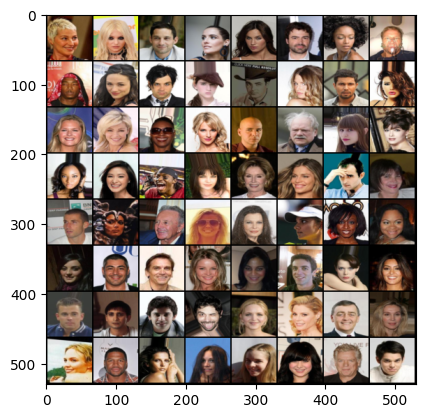

In [ ]:
plt.imshow(np.transpose(vutils.make_grid(real_images[:64], padding=2, normalize=True).cpu(),(1,2,0)))

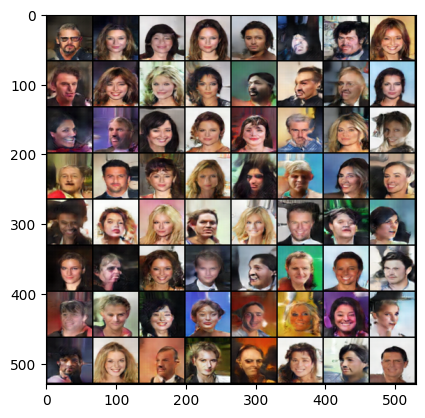

In [ ]:
plt.imshow(np.transpose(vutils.make_grid(fake_images[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Question 3: Please annotate several real and synthetic images using fairface.
Plot the results are there biases within the real images, the synthetic ones ?
Are the biases the same? Why in your opinion?

In [ ]:
## TO COMPLETE

## DDPM

In [ ]:
os.chdir("/content/ddpm")

In [ ]:
nb_images_to_pick = 200
fake_images_paths = [ os .path.join("ddpm/generated", img) for img in os.listdir("ddpm/generated") ]

rnd_idx = random.sample(list(np.arange(len(fake_images_paths))), nb_images_to_pick)
fake_images_paths = [fake_images_paths[i] for i in rnd_idx]


real_images_paths =  torchvision.datasets.ImageFolder("ffhq/thumbnails128x128")
rnd_idx = random.sample(list(np.arange(len(real_images_paths))), nb_images_to_pick)
real_images_paths = [real_images_paths[i] for i in rnd_idx]

Question 4: Please annotate several real and synthetic images using fairface. Plot the results are there biases within the real images, the synthetic ones? Are the biases the same? Why in your opinion?

In [ ]:
# TO COMPLETE

## Using FavCi2D

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=03e3e489c6f19c1c7f4fe02dbc72b30c044ffa1af471bce96f2e0a779d40b4c0
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
from collections import OrderedDict
def load_metadata(file_path):
    file = open(file_path, "r")
    file_lines = file.readlines()
    file.close()
    attributes_header = file_lines[0]
    if attributes_header[-1] == "\n":
        attributes_header = attributes_header[:-1]
    attributes_list = attributes_header.split(";")
    attributes_list = [elt.strip() for elt in attributes_list]
    resulting_dict = OrderedDict()
    for attribute in attributes_list:
        resulting_dict[attribute] = []
    for line in file_lines[1:]:
        line:str = line.strip()
        line_attributes = line.split(";")
        for attribute, line_attribute in zip(attributes_list, line_attributes):
            try:
                if int(line_attribute) == float(line_attribute):
                    resulting_dict[attribute].append(int(line_attribute))
                else:
                    resulting_dict[attribute].append(float(line_attribute))
            except Exception as e:
                if line_attribute == "unknown":
                    resulting_dict[attribute].append(-1)
                else:
                    resulting_dict[attribute].append(line_attribute)
    return resulting_dict

In [ ]:
metadata = load_metadata("FAVCID/metadata.txt")
favcid_dict = torch.load("FAVCID/features.pt", map_location="cpu")

In [ ]:
def concatenate_all(dict_, nb_kept_sample = 7000, metadata=None):
    result = [] #None
    demographic_segment = []
    for key in tqdm(dict_.keys()):
        key_metadata_idx = metadata['ID'].index(key)

        key_array = dict_[key].numpy()
        key_array = key_array / np.linalg.norm(key_array, axis = 1).reshape((-1,1))
        if metadata is not None:
            demographic_segment = demographic_segment + [metadata["CONTINENT"][key_metadata_idx] + "-" + metadata["GENDER"][key_metadata_idx] for _ in range(len(key_array))]

        result = result + list(key_array)
    idx_to_keep = random.sample(list(np.arange(len(result))), nb_kept_sample)
    return np.asarray([result[i] for i in idx_to_keep]), np.asarray([demographic_segment[i] for i in idx_to_keep])

In [ ]:
favcid_feats, favcid_segments = concatenate_all(favcid_dict, 2000, metadata)

100%|██████████| 19441/19441 [00:18<00:00, 1061.14it/s]


Question 5: Check that all the norms of the features are equal to one. Prove that L2 distance between two normalized vectors is equivalent to the cosine distance

Question 6: Do you think we can use PCA (principal component analysis) in order to visualize the features? What about TSNE (t-distributed stochastic neighbor embedding)  ?

We will here use an alternative to TSNE called UMAP

We want to use the embeddings of FavCI2D in order to annotate the DDPM and FFHQ images. (You can load the corresponding features of these datasets).


Question 7 : Explain the characteristics of the projection performed by UMAP (you might need to check the documentation). After visualizing the FAVCID data using UMAP, explain which approach you think you can use and which approaches are not adapted from your opinion in order to perform such an annotation.

Implement it

In [ ]:
import umap
reducer = umap.UMAP()
projected_embeddings = reducer.fit_transform(favcid_feats)


/tmp/ipykernel_465712/2160190014.py:5: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


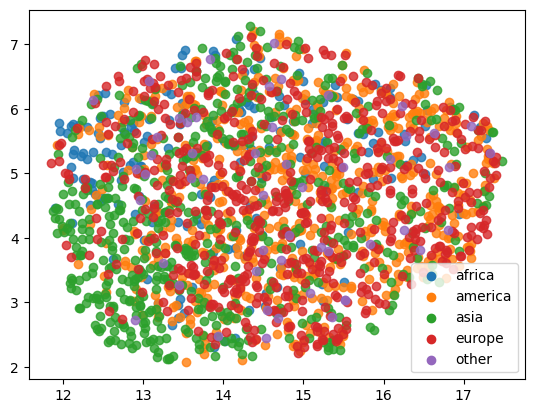

In [ ]:

favcid_origin = np.asarray([elt.split("-")[0] for elt in favcid_segments])
for label in np.unique(favcid_origin):
    plt.scatter(projected_embeddings[favcid_origin == label, 0], projected_embeddings[favcid_origin== label, 1], label = label, alpha=0.8)
leg  =plt.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)

In [ ]:
ddpm_feats = torch.load("ddpm/features.pt", map_location="cpu")


Question 8: Compare the results your obtain with the one you had with FairFace. Which approach do you think is better and why ?

Question 9: Project DDPM FFHQ FAVCID in 2D using TSNE and UMAP. Are you able to see some shift between datasets? If yes where do you think it can come?
Are you able to identify some clusters within your visualization?

## Evaluating model Performances

The Face Recognition task consists of guessing whether two pictures represent the same person (identity) or not.
A common way to solve the Face Recognition task is to first train a deep neural network to perform a classification task on faces, we then get rid of the last classification layers. We then use the resulting model, who output now features vectors, in order to compute distances between images.

Two distance files are provided. In these files, each line contains 3 columns. The two first contain the image names that are under this format: <identity>_<img_idx>.png and the last one is the distance between the two pictures in the model embedding space. They correspond to the distances between the FAVCID images obtained while using a model trained on a demographically balanced (WikiDiv) set and an unbalanced set (WikiFamous).

In order to evaluate the model's performances we will compute the accuracy metric in a CrossValidation setup.
In order to do so you will compute the accuracy ten times. Each time, ten percent of the dataset is used in order to find a threshold on the distance that separates the same identitities from different ones. Then you will compute the accuracy obtained with the previously computed threshold on the remaining 90% distances.

In [ ]:
def compute_model_accuracy(distance_file):
    #TO BE Implemented

Question 10 Do the same but now compute the accuracy for each demographic segment (i.e. each combination of gender/continent)  separately. What can you notice? Which metric could you use to reflect a model's fairness ?